In [29]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# Libreria para estimar regresión
import statsmodels.formula.api as sm
# Libreria para metricas 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Libreria para separar en train y test
from sklearn.model_selection import train_test_split
# Libreria para estandarizar la data 
from sklearn.preprocessing import StandardScaler
# Seteo para que no se muestre notación científica
np.set_printoptions(suppress=True)

In [30]:
# Levanto data
url = 'https://raw.githubusercontent.com/xlisouski/DataCoder/main/train.csv'
df = pd.read_csv(url, sep = ',')

# Preprocesamiento

In [31]:
# Preprocesamiento
# Primero genero la variable logaritmica 
df['SalePrice_Log'] = np.log(df['SalePrice'])
# Genero binarias
features_categoricas = df.select_dtypes(include=['object'])
valores_distintos = features_categoricas.nunique()
col_aTransformar = valores_distintos.index[valores_distintos<=5]
df_dummies = pd.get_dummies(df[col_aTransformar],drop_first=True)
df = pd.concat([df, df_dummies], axis=1)

# Genero target encoding
# Foundation
df['Foundation_Agg'] = np.where(df['Foundation'].isin(['BrkTil','CBlock','PConc']),
                                df['Foundation'],
                                'Otro')
resultados = df.groupby('Foundation_Agg').agg(
    Cant = ('SalePrice', 'count'),              
    Promedio = ('SalePrice', 'mean'),            
    Mediana = ('SalePrice', 'median')    
).reset_index()
resultados.rename(columns={'Mediana': 'Mediana_Foundation'}, inplace=True)
df = df.merge(resultados[['Foundation_Agg','Mediana_Foundation']],
              left_on = 'Foundation_Agg',
              right_on = 'Foundation_Agg',
              how = 'left')

# Genero variables con factor tiempo
df['Antig_Viv'] = df['YrSold'] - df['YearBuilt']
df['Antig_Rem'] = df['YrSold'] - df['YearRemodAdd']
df['Antig_Garage'] = np.where((df['GarageYrBlt'] > df['YrSold']) | (df['GarageYrBlt'].isnull()),
                            -999,
                            df['YrSold'] - df['GarageYrBlt'])

# Renombro features problemáticas
df = df.rename(columns={'1stFlrSF': 'V_1stFlrSF'})
df = df.rename(columns={'2ndFlrSF': 'V_2ndFlrSF'})
df = df.rename(columns={'3SsnPorch': 'V_3SsnPorch'})

# TRAIN Y TEST

In [32]:
# Separo usando el paquete sklearn
df_train,df_test = train_test_split(df,
                                    test_size = 0.3, #Porcentaje de muestra test 
                                    random_state = 42) #Semilla

# Modelo 1
Voy a generar un primer modelo (ahora usando el paquete sklearn) con el top 30 de las variables con mayor coeficiente de correlación. 

In [33]:
# Ajusto el modelo
features_base = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'V_1stFlrSF',
       'Antig_Viv', 'Antig_Rem']
model_formula = 'SalePrice_Log ~ ' + ' + '.join(df_train[features_base].columns)
lm1   = sm.ols(formula = model_formula, data = df_train).fit()

In [34]:
coeficientes = lm1.params
print('Coeficientes:')
print(coeficientes.head(21).round(6))

Coeficientes:
Intercept      10.914955
OverallQual     0.097516
GrLivArea       0.000208
GarageCars      0.100523
TotalBsmtSF     0.000051
V_1stFlrSF      0.000066
Antig_Viv      -0.001728
Antig_Rem      -0.002104
dtype: float64


In [35]:
pvalores_1 = lm1.pvalues
print('P-Valores:')
print(pvalores_1.head(21).round(6).sort_values(ascending=False))

P-Valores:
TotalBsmtSF    0.027520
V_1stFlrSF     0.015118
Intercept      0.000000
OverallQual    0.000000
GrLivArea      0.000000
GarageCars     0.000000
Antig_Viv      0.000000
Antig_Rem      0.000000
dtype: float64


In [36]:
# Genero columna de predicciones
df_train['Pred_1'] = lm1.predict(df_train)
df_test['Pred_1'] = lm1.predict(df_test)

# Modelo 2
Vamos a intentar mejorar las variables de entrada

## TotalBsmtSF
Esta varaible toma valores muy dispersos. 
<br></br>
**Estrategia propuesta:**
* Identificar outliers utilizando el percentil 99 de la variable y topearla 
* Suavizar la varaible aplicando logaritmo del dato + 1, para evitar problemas en los 0 
* Validar si la transformación mejoró los resultados 

In [37]:
# 1) Método describe: ¿Qué valores toma la variable?
df['TotalBsmtSF'].describe()

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice_Log'>

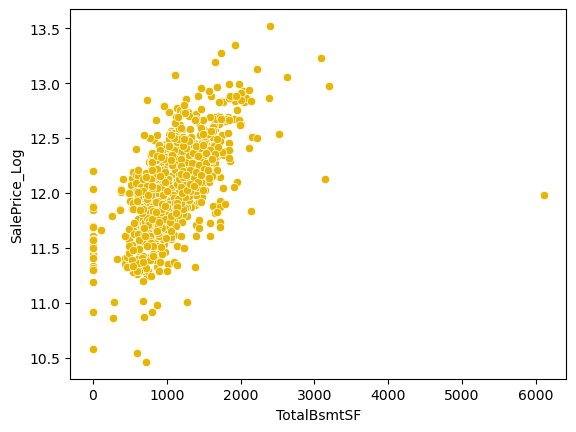

In [12]:
# 2) Visualmente, cómo es la relación con el target? 
sns.scatterplot(data = df_train,
                x = 'TotalBsmtSF',
                y = 'SalePrice_Log',
                color = '#E7B602')

In [38]:
## 3) Outliers: topeemos la variable en el percentil 99
# Calculo el percentil: 
percentil_99 = np.percentile(df_train['TotalBsmtSF'], 99)

# Topeo:
df_train['TotalBsmtSF_top'] = np.where(df_train['TotalBsmtSF'] > percentil_99,
                                      percentil_99,
                                      df_train['TotalBsmtSF'])
df_test['TotalBsmtSF_top'] = np.where(df_test['TotalBsmtSF'] > percentil_99,
                                      percentil_99,
                                      df_test['TotalBsmtSF'])

<Axes: xlabel='TotalBsmtSF_top', ylabel='SalePrice_Log'>

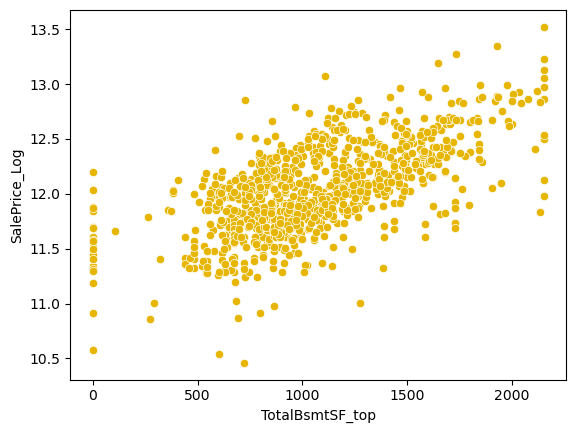

In [39]:
# 4) Visualmente, se ven cambios? 
sns.scatterplot(data = df_train,
                x = 'TotalBsmtSF_top',
                y = 'SalePrice_Log',
                color = '#E7B602')

In [40]:
# 5) Calculo logaritmo
df_train['TotalBsmtSF_Log'] = np.log(df_train['TotalBsmtSF_top']+1)
df_test['TotalBsmtSF_Log'] = np.log(df_test['TotalBsmtSF_top']+1)

## V_1stFlrSF
Esta varaible toma valores muy dispersos. 

In [41]:
df['V_1stFlrSF'].describe()

count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: V_1stFlrSF, dtype: float64

<Axes: xlabel='V_1stFlrSF', ylabel='SalePrice_Log'>

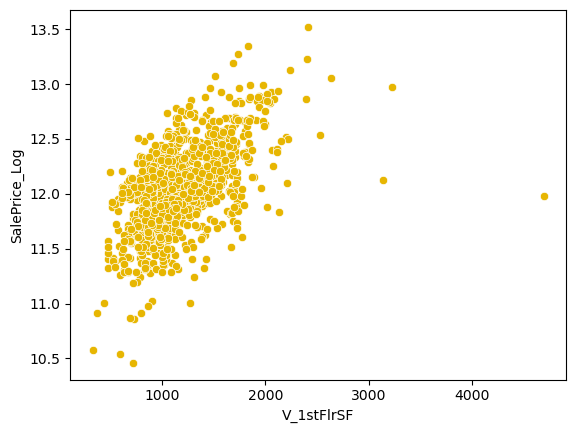

In [42]:
sns.scatterplot(data = df_train,
                x = 'V_1stFlrSF',
                y = 'SalePrice_Log',
                color = '#E7B602')

In [43]:
## Outliers: topeemos la variable en el percentil 99
percentil_99 = np.percentile(df_train['V_1stFlrSF'], 99)

df_train['V_1stFlrSF_top'] = np.where(df_train['V_1stFlrSF'] > percentil_99,
                                      percentil_99,
                                      df_train['V_1stFlrSF'])
df_test['V_1stFlrSF_top'] = np.where(df_test['V_1stFlrSF'] > percentil_99,
                                      percentil_99,
                                      df_test['V_1stFlrSF'])

<Axes: xlabel='V_1stFlrSF_top', ylabel='SalePrice_Log'>

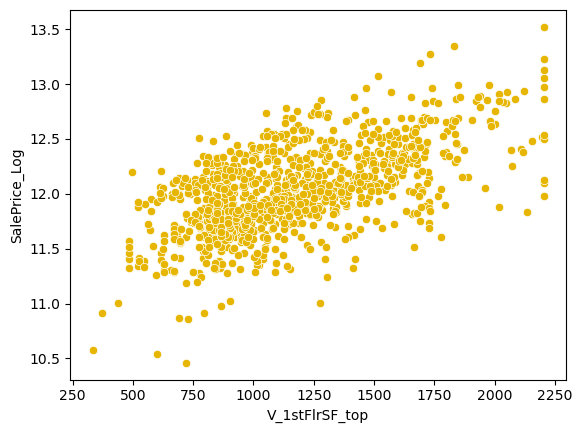

In [44]:
sns.scatterplot(data = df_train,
                x = 'V_1stFlrSF_top',
                y = 'SalePrice_Log',
                color = '#E7B602')

In [45]:
df_train['V_1stFlrSF_Log'] = np.log(df_train['V_1stFlrSF_top']+1)
df_test['V_1stFlrSF_Log'] = np.log(df_test['V_1stFlrSF_top']+1)
df_train['V_1stFlrSF_Log'].describe()

count    1022.000000
mean        7.012471
std         0.312385
min         5.814131
25%         6.792063
50%         7.000790
75%         7.239215
max         7.698796
Name: V_1stFlrSF_Log, dtype: float64

# Modelo 2: Modelado

In [46]:
# Ajusto el modelo
features_2 = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF_Log', 'V_1stFlrSF_Log',
       'Antig_Viv', 'Antig_Rem']
model_formula = 'SalePrice_Log ~ ' + ' + '.join(df_train[features_2].columns)
lm2 = sm.ols(formula = model_formula, data = df_train).fit()

In [47]:
coeficientes = lm2.params
print('Coeficientes:')
print(coeficientes.head(21).round(6))

Coeficientes:
Intercept          9.522410
OverallQual        0.092149
GrLivArea          0.000201
GarageCars         0.087693
TotalBsmtSF_Log    0.024810
V_1stFlrSF_Log     0.203322
Antig_Viv         -0.001855
Antig_Rem         -0.002026
dtype: float64


In [48]:
pvalores = lm2.pvalues
print('P-Valores:')
print(pvalores.head(21).round(6).sort_values(ascending=False))

P-Valores:
TotalBsmtSF_Log    0.000001
Intercept          0.000000
OverallQual        0.000000
GrLivArea          0.000000
GarageCars         0.000000
V_1stFlrSF_Log     0.000000
Antig_Viv          0.000000
Antig_Rem          0.000000
dtype: float64


In [49]:
# Genero columna de predicciones
df_train['Pred_2'] = lm2.predict(df_train)
df_test['Pred_2'] = lm2.predict(df_test)

# Comparemos los dos modelos 
Hay muchas maneras de decidir si un modelo es superior al otro. 
<br></br>
En el caso particular de regresión, también es de suma importancia interpretar los coeficientes para ver que estén indicando una relación correcta. En este caso no lo vamos a hacer, vamos a dar por "buenas" las relaciones y vamos a limitarnos a estudiar los resultados de ambos algoritmos. 

## Distribuciones
¿Qué distribución tienen las predicciones de cada modelo?

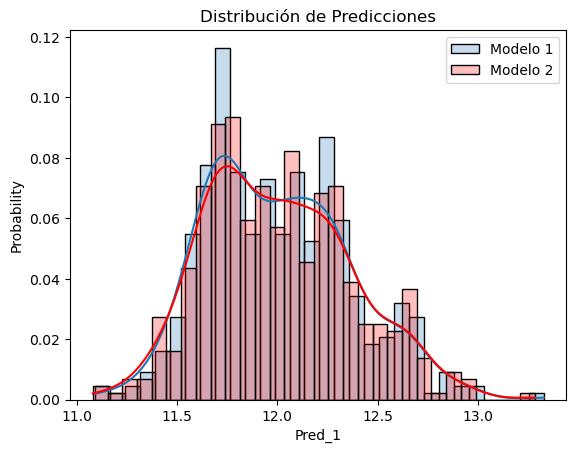

In [50]:
# Luego grafico
plt.figure()
# Histograma
sns.histplot(data = df_test,
             x = 'Pred_1',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
            label = 'Modelo 1')
sns.histplot(data  = df_test, 
             x = 'Pred_2', 
             bins = 30, 
             alpha = 0.25, 
             kde = True, 
             stat='probability', 
             color='red', 
             label='Modelo 2')

plt.title('Distribución de Predicciones')
plt.legend()
plt.show()

## Métricas
Calculemos el R cuadrado y el RMSE. 

In [51]:
rmse_1_test= mean_squared_error(df_test['SalePrice_Log'], df_test['Pred_1'], squared=False)
r_squared_1_test = r2_score(df_test['SalePrice_Log'], df_test['Pred_1'])
rmse_1_train = mean_squared_error(df_train['SalePrice_Log'], df_train['Pred_1'], squared=False)
r_squared_1_train = r2_score(df_train['SalePrice_Log'], df_train['Pred_1'])

rmse_2_test = mean_squared_error(df_test['SalePrice_Log'], df_test['Pred_2'], squared=False)
r_squared_2_test = r2_score(df_test['SalePrice_Log'], df_test['Pred_2'])
rmse_2_train = mean_squared_error(df_train['SalePrice_Log'], df_train['Pred_2'], squared=False)
r_squared_2_train = r2_score(df_train['SalePrice_Log'], df_train['Pred_2'])

In [52]:
print('RMSE')
print('MODELO 1')
print('TEST: ' + str(rmse_1_test.round(4)))
print('TRAIN: ' + str(rmse_1_train.round(4)))
print('----------------')
print('MODELO 2')
print('TEST: ' + str(rmse_2_test.round(4)))
print('TRAIN: ' + str(rmse_2_train.round(4)))

RMSE
MODELO 1
TEST: 0.1636
TRAIN: 0.1731
----------------
MODELO 2
TEST: 0.1563
TRAIN: 0.1653


In [53]:
print('r - 2')
print('MODELO 1')
print('TEST: ' + str(r_squared_1_test.round(4)))
print('TRAIN: ' + str(r_squared_1_train.round(4)))
print('----------------')
print('MODELO 2')
print('TEST: ' + str(r_squared_2_test.round(4)))
print('TRAIN: ' + str(r_squared_2_train.round(4)))

r - 2
MODELO 1
TEST: 0.8422
TRAIN: 0.8067
----------------
MODELO 2
TEST: 0.8561
TRAIN: 0.8237
